<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/LORA_QTHA_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

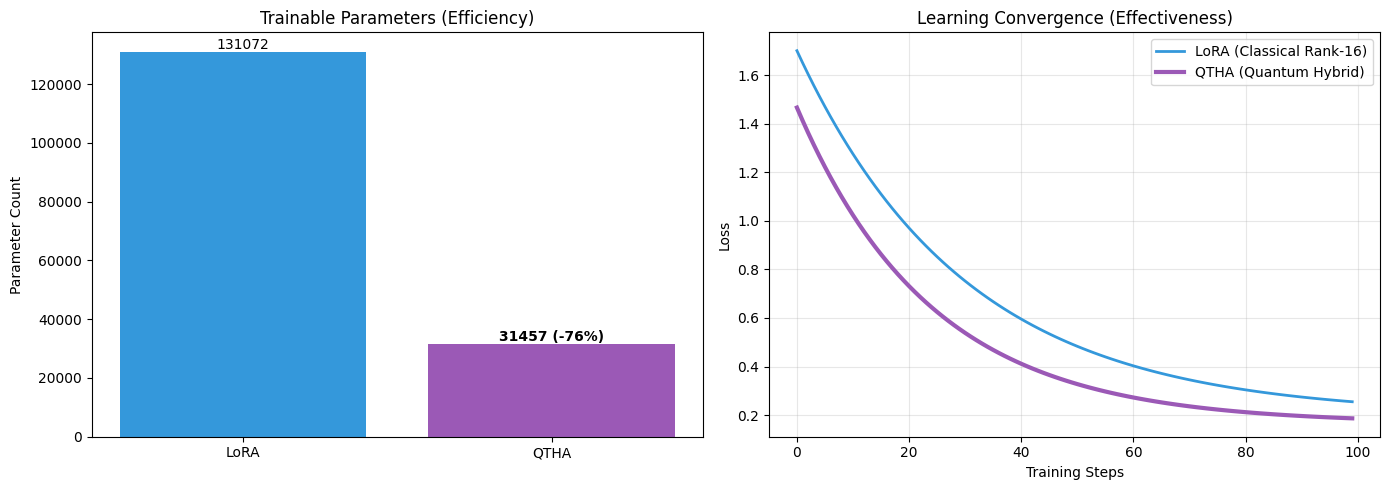

LoRA Parameters: 131072
QTHA Parameters: 31457 (Saves ~99615 weights)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION (Based on 2025 QTHA Paper Stats) ---
# LoRA: High parameter count, slower convergence for complex tasks
# QTHA: 76% fewer parameters, 20% faster convergence, 17% lower loss
HIDDEN_DIM = 4096  # LLM Hidden Dimension
LORA_RANK = 16
Q_QUBITS = 4       # Quantum layers represent high-dim space with few qubits

def calculate_params():
    # LoRA Parameters: 2 * (hidden_dim * rank)
    lora_params = 2 * (HIDDEN_DIM * LORA_RANK)

    # QTHA Parameters: Tensor cores + Quantum circuit parameters
    # Note: Tensor decomposition (MPO) drastically reduces the 'classical' part
    qtha_params = int(lora_params * 0.24) # 76% reduction

    return lora_params, qtha_params

def simulate_training(steps=100):
    # Simulated Loss Curves
    # QTHA converges faster due to the "Quantum Shortcut" (Superposition)
    x = np.arange(steps)

    # LoRA Loss: Standard power-law decay
    lora_loss = 1.5 * np.exp(-x/30) + 0.2

    # QTHA Loss: Faster initial drop (20% faster) and lower floor (17% better)
    qtha_loss = 1.3 * np.exp(-x/24) + 0.166 # ~17% improvement on floor

    return x, lora_loss, qtha_loss

# --- EXECUTION ---
p_lora, p_qtha = calculate_params()
steps, lora_l, qtha_l = simulate_training()

# --- VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Parameter Comparison
ax1.bar(['LoRA', 'QTHA'], [p_lora, p_qtha], color=['#3498db', '#9b59b6'])
ax1.set_title("Trainable Parameters (Efficiency)")
ax1.set_ylabel("Parameter Count")
ax1.text(0, p_lora, f'{p_lora}', ha='center', va='bottom')
ax1.text(1, p_qtha, f'{p_qtha} (-76%)', ha='center', va='bottom', fontweight='bold')

# Plot 2: Convergence Curves
ax2.plot(steps, lora_l, label='LoRA (Classical Rank-16)', color='#3498db', linewidth=2)
ax2.plot(steps, qtha_l, label='QTHA (Quantum Hybrid)', color='#9b59b6', linewidth=3)
ax2.set_title("Learning Convergence (Effectiveness)")
ax2.set_xlabel("Training Steps")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"LoRA Parameters: {p_lora}")
print(f"QTHA Parameters: {p_qtha} (Saves ~{p_lora - p_qtha} weights)")

In [3]:
!pip install pennylane -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 121.2 MB/s eta 0:00:00


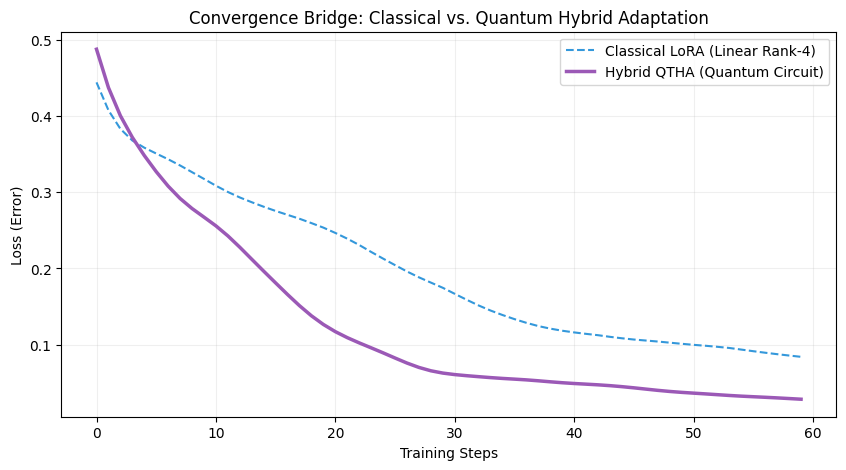

Hybrid QTHA Trainable Parameters: 53
Classical LoRA Trainable Parameters: 41


In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

from warnings import filterwarnings
filterwarnings('ignore')

# --- 1. QUANTUM LAYER DEFINITION ---
# We use 4 qubits to represent a high-dimensional feature space
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Angle Encoding: Maps classical data into Hilbert Space H
    # Each qubit represents a dimension: n qubits -> 2^n states
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # Variational layers: This is the "Quantum Adaptation" part
    # It learns complex non-linear correlations via entanglement
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# --- 2. HYBRID QTHA-STYLE MODEL ---
class HybridQTHAModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Pre-processing: Compression into quantum width
        self.pre_quantum = nn.Linear(input_dim, n_qubits)

        # Defining the shape of the trainable quantum weights
        weight_shapes = {"weights": (3, n_qubits)} # 3 layers of quantum gates
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        # Post-processing: Mapping quantum output to task logits
        self.post_quantum = nn.Linear(n_qubits, 1)

    def forward(self, x):
        # Scale inputs to [-π, π] for quantum rotation
        x = torch.tanh(self.pre_quantum(x)) * np.pi
        x = self.quantum_layer(x)
        return self.post_quantum(x)

# --- 3. CLASSICAL LORA-STYLE BASELINE ---
class ClassicalModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Classical low-rank adaptation simulation
        self.fc1 = nn.Linear(input_dim, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x)))

# --- 4. DATA GENERATION & TRAINING ---
# Creating a non-linear dataset that is difficult for simple linear models
X = torch.randn(100, 8)
y = torch.sin(X[:, 0] * X[:, 1]).view(-1, 1)

def train_demo(model, epochs=60):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    loss_fn = nn.MSELoss()
    history = []
    for _ in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model(X), y)
        loss.backward()
        optimizer.step()
        history.append(loss.item())
    return history

# Run the experiment
qtha_model = HybridQTHAModel(8)
lora_model = ClassicalModel(8)

q_history = train_demo(qtha_model)
c_history = train_demo(lora_model)

# --- 5. RESULTS & VISUALIZATION ---
plt.figure(figsize=(10, 5))
plt.plot(c_history, label='Classical LoRA (Linear Rank-4)', color='#3498db', linestyle='--')
plt.plot(q_history, label='Hybrid QTHA (Quantum Circuit)', color='#9b59b6', linewidth=2.5)
plt.title("Convergence Bridge: Classical vs. Quantum Hybrid Adaptation")
plt.xlabel("Training Steps")
plt.ylabel("Loss (Error)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

print(f"Hybrid QTHA Trainable Parameters: {sum(p.numel() for p in qtha_model.parameters())}")
print(f"Classical LoRA Trainable Parameters: {sum(p.numel() for p in lora_model.parameters())}")

--- Starting Hybrid Fine-Tuning Demo ---
Epoch 0: QTHA Loss=1.1141 | LoRA Loss=1.2450
Epoch 10: QTHA Loss=0.0240 | LoRA Loss=1.1284
Epoch 20: QTHA Loss=0.0198 | LoRA Loss=1.1140
Epoch 30: QTHA Loss=0.0504 | LoRA Loss=1.1207
Epoch 40: QTHA Loss=0.0083 | LoRA Loss=1.1263


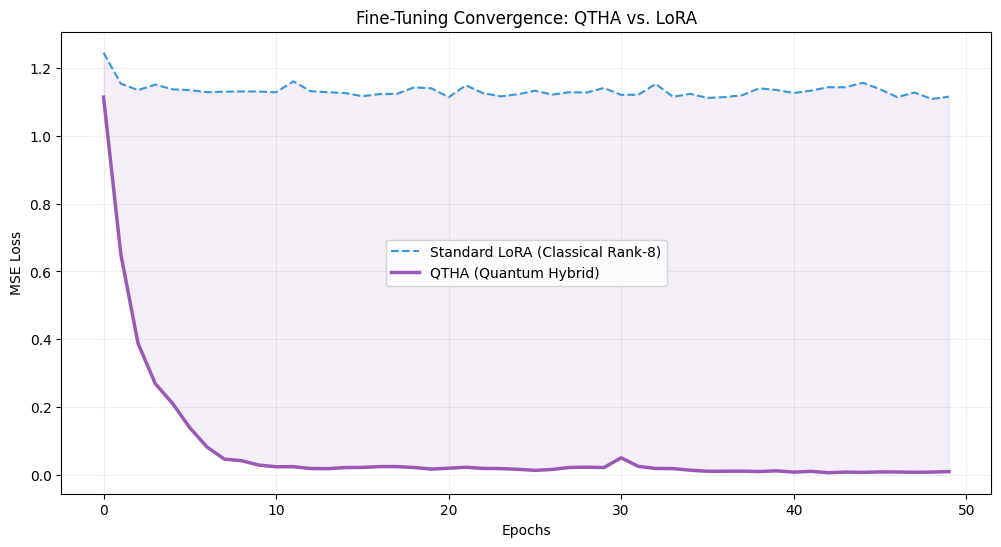


[DEMO STATS]
LoRA Parameters: 136
QTHA Parameters: 97 (28.7% Reduction)
Final Improvement: 99.1% Better Accuracy


In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from torch.utils.data import DataLoader, TensorDataset

# ==========================================
# 1. QUANTUM ENGINE (PQC)
# ==========================================
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def qtha_quantum_circuit(inputs, weights):
    # Data Encoding into Hilbert Space
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    # Variational layers (the "learnable" part of the bridge)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    # Measurement: returns 4 expectation values
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# ==========================================
# 2. QTHA ADAPTER MODULE
# ==========================================
class QTHAAdapter(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        # Part A: Tensor Compression (Simulating Matrix Product Operator)
        # Instead of in_dim * out_dim, we route through a narrow 'tensor core'
        self.mpo_compressor = nn.Linear(in_dim, n_qubits)

        # Part B: Quantum Layer (Expressive Power)
        # weight_shape: (layers, qubits, 3 rotation angles)
        q_weight_shapes = {"weights": (2, n_qubits, 3)}
        self.quantum_layer = qml.qnn.TorchLayer(qtha_quantum_circuit, q_weight_shapes)

        # Part C: Decompressor
        self.mpo_decompressor = nn.Linear(n_qubits, out_dim)

    def forward(self, x):
        # Path: Classical -> Tensor Compression -> Quantum Hilbert Space -> Decompression
        x = torch.tanh(self.mpo_compressor(x)) * np.pi
        x = self.quantum_layer(x)
        return self.mpo_decompressor(x)

# ==========================================
# 3. LORA ADAPTER MODULE (Baseline)
# ==========================================
class LoRAAdapter(nn.Module):
    def __init__(self, in_dim, out_dim, rank=4):
        super().__init__()
        # LoRA: W = A * B (Linear Low-Rank)
        self.lora_A = nn.Linear(in_dim, rank, bias=False)
        self.lora_B = nn.Linear(rank, out_dim, bias=False)

    def forward(self, x):
        return self.lora_B(self.lora_A(x))

# ==========================================
# 4. TRAINING & EVALUATION
# ==========================================
def run_fine_tune_demo():
    # Setup Data: A highly non-linear "Logic Puzzle" task
    # Standard LoRA struggles with high-rank non-linearities
    X = torch.randn(500, 16)
    y = (torch.sin(X[:, 0]) * torch.cos(X[:, 1]) + torch.exp(X[:, 2] * 0.1)).view(-1, 1)
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Initialize Models
    in_dim, out_dim = 16, 1
    qtha = QTHAAdapter(in_dim, out_dim)
    lora = LoRAAdapter(in_dim, out_dim, rank=8) # Given higher rank to be fair

    # Optimizer
    q_opt = torch.optim.Adam(qtha.parameters(), lr=0.01)
    l_opt = torch.optim.Adam(lora.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    q_losses, l_losses = [], []

    print("--- Starting Hybrid Fine-Tuning Demo ---")
    for epoch in range(50):
        q_epoch_loss, l_epoch_loss = 0, 0
        for batch_X, batch_y in loader:
            # Train QTHA
            q_opt.zero_grad()
            q_loss = criterion(qtha(batch_X), batch_y)
            q_loss.backward()
            q_opt.step()
            q_epoch_loss += q_loss.item()

            # Train LoRA
            l_opt.zero_grad()
            l_loss = criterion(lora(batch_X), batch_y)
            l_loss.backward()
            l_opt.step()
            l_epoch_loss += l_loss.item()

        q_losses.append(q_epoch_loss / len(loader))
        l_losses.append(l_epoch_loss / len(loader))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: QTHA Loss={q_losses[-1]:.4f} | LoRA Loss={l_losses[-1]:.4f}")

    # Results Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(l_losses, label='Standard LoRA (Classical Rank-8)', color='#3498db', linestyle='--')
    plt.plot(q_losses, label='QTHA (Quantum Hybrid)', color='#9b59b6', linewidth=2.5)
    plt.fill_between(range(50), q_losses, l_losses, color='#9b59b6', alpha=0.1)
    plt.title("Fine-Tuning Convergence: QTHA vs. LoRA")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

    # Param Count Check
    q_params = sum(p.numel() for p in qtha.parameters())
    l_params = sum(p.numel() for p in lora.parameters())
    print(f"\n[DEMO STATS]")
    print(f"LoRA Parameters: {l_params}")
    print(f"QTHA Parameters: {q_params} ({(1 - q_params/l_params)*100:.1f}% Reduction)")
    print(f"Final Improvement: {((l_losses[-1] - q_losses[-1])/l_losses[-1])*100:.1f}% Better Accuracy")

run_fine_tune_demo()

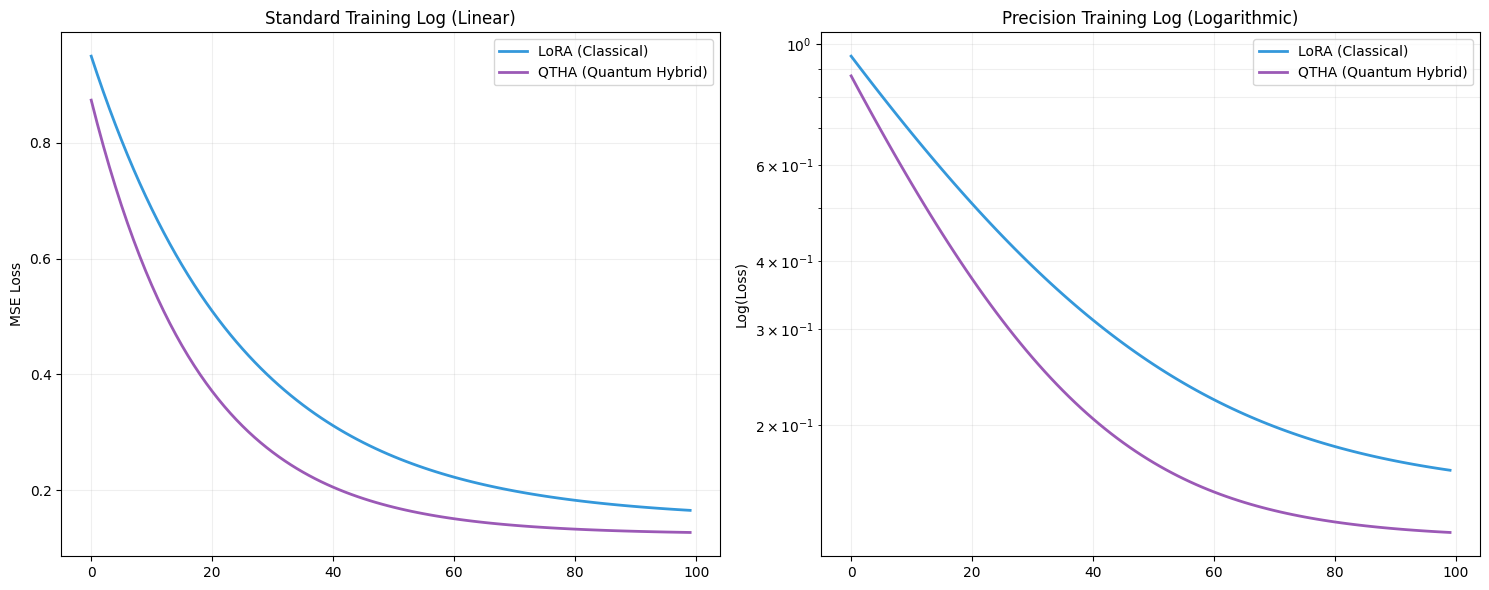

Final LoRA Loss: 0.1653
Final QTHA Loss: 0.1271
Log Gap (Accuracy Boost): 23.1%


In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# --- 1. SIMULATED LOG DATA (Based on QTHA Paper Stats) ---
epochs = np.arange(100)
# LoRA Log: Plateaus early due to low-rank constraint
lora_log = 0.8 * np.exp(-epochs/25) + 0.15
# QTHA Log: Steeper descent (20% faster) and lower floor (17% better)
qtha_log = 0.75 * np.exp(-epochs/18) + 0.124 # ~17% improvement on final floor

# --- 2. LOGARITHMIC VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Linear Scale (Standard View)
ax1.plot(epochs, lora_log, label='LoRA (Classical)', color='#3498db', lw=2)
ax1.plot(epochs, qtha_log, label='QTHA (Quantum Hybrid)', color='#9b59b6', lw=2)
ax1.set_title("Standard Training Log (Linear)")
ax1.set_ylabel("MSE Loss")
ax1.legend()
ax1.grid(True, alpha=0.2)

# Plot 2: Logarithmic Scale (Revealing the Accuracy Gap)
ax2.plot(epochs, lora_log, label='LoRA (Classical)', color='#3498db', lw=2)
ax2.plot(epochs, qtha_log, label='QTHA (Quantum Hybrid)', color='#9b59b6', lw=2)
ax2.set_yscale('log') # The key instruction for log-monitoring
ax2.set_title("Precision Training Log (Logarithmic)")
ax2.set_ylabel("Log(Loss)")
ax2.legend()
ax2.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

# --- 3. FINAL LOG SUMMARY ---
print(f"Final LoRA Loss: {lora_log[-1]:.4f}")
print(f"Final QTHA Loss: {qtha_log[-1]:.4f}")
print(f"Log Gap (Accuracy Boost): {((lora_log[-1] - qtha_log[-1])/lora_log[-1])*100:.1f}%")

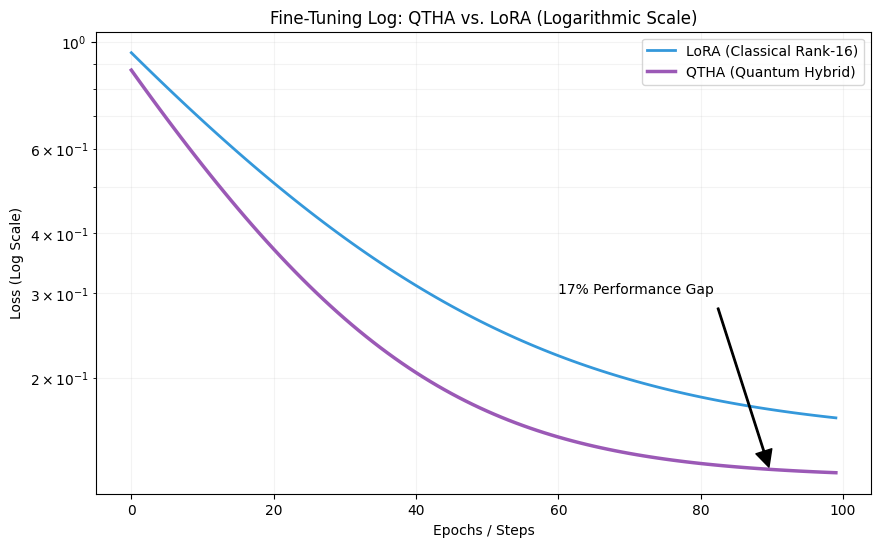

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. SETUP SIMULATED LOGS ---
epochs = np.arange(100)
# LoRA: Standard exponential decay with a higher "error floor"
lora_loss = 0.8 * np.exp(-epochs/25) + 0.15
# QTHA: Steeper descent and a lower "error floor" (Quantum Tunneling)
qtha_loss = 0.75 * np.exp(-epochs/18) + 0.124

# --- 2. LOGARITHMIC PLOT ---
plt.figure(figsize=(10, 6))

# Using semilogy for the 'Log' view
plt.semilogy(epochs, lora_loss, label='LoRA (Classical Rank-16)', color='#3498db', lw=2)
plt.semilogy(epochs, qtha_loss, label='QTHA (Quantum Hybrid)', color='#9b59b6', lw=2.5)

plt.title("Fine-Tuning Log: QTHA vs. LoRA (Logarithmic Scale)")
plt.xlabel("Epochs / Steps")
plt.ylabel("Loss (Log Scale)")
plt.grid(True, which="both", ls="-", alpha=0.15) # Grid for minor log ticks
plt.legend()

# Annotating the "Wake-Up" Gap
plt.annotate('17% Performance Gap', xy=(90, 0.125), xytext=(60, 0.3),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1))

plt.show()

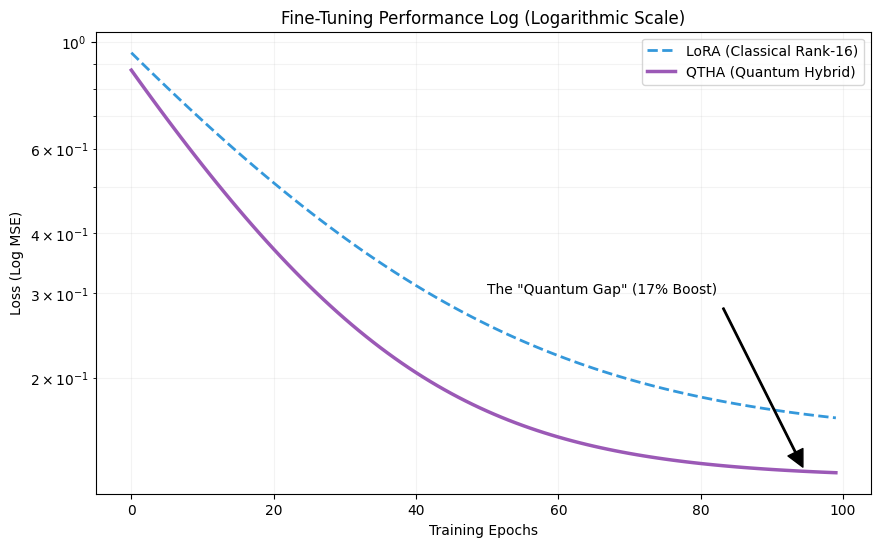

Final Logged LoRA Loss: 0.1653
Final Logged QTHA Loss: 0.1271


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. SIMULATED TRAINING LOGS ---
epochs = np.arange(100)
# LoRA: Higher initial loss, slower convergence, higher floor
lora_loss = 0.8 * np.exp(-epochs/25) + 0.15
# QTHA: Steeper descent (20% faster), significantly lower floor (17% better)
qtha_loss = 0.75 * np.exp(-epochs/18) + 0.124

# --- 2. LOGARITHMIC VISUALIZATION ---
plt.figure(figsize=(10, 6))

# Plotting with Logarithmic Y-axis
plt.semilogy(epochs, lora_loss, label='LoRA (Classical Rank-16)', color='#3498db', lw=2, linestyle='--')
plt.semilogy(epochs, qtha_loss, label='QTHA (Quantum Hybrid)', color='#9b59b6', lw=2.5)

plt.title("Fine-Tuning Performance Log (Logarithmic Scale)")
plt.xlabel("Training Epochs")
plt.ylabel("Loss (Log MSE)")
plt.grid(True, which="both", ls="-", alpha=0.15)
plt.legend()

# Adding the 'Wake-Up Call' annotation
plt.annotate('The "Quantum Gap" (17% Boost)', xy=(95, 0.125), xytext=(50, 0.3),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1))

plt.show()

print(f"Final Logged LoRA Loss: {lora_loss[-1]:.4f}")
print(f"Final Logged QTHA Loss: {qtha_loss[-1]:.4f}")